In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import _pickle as cPickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt

import xgboost as xgb


# Process Dataset

In [ ]:
# Load in our data
df_train_full=pd.read_csv('df_train_full.csv',header=0)
df_test=pd.read_csv('df_test.csv',header=0)
X_train_full = df_train_full.drop(columns=["YY"])
Y_train_full = df_train_full.YY
X_test = df_test.drop(columns=["YY"])
Y_test = df_test.YY

Our benchmarks for AUC and classification accuracy on the test set are $0.754$ and $0.801$, respectively. 

In [ ]:
AUC_BENCHMARK = .754
ACCURACY_BENCHMARK = 0.801

AUC_BENCHMARK_mc = 0.726
ACCURACY_BENCHMARK_mc = 0.796

# FFNN

Feed-Forward Neural Networks are a type of Artificial Neural Network that tend to perform well on classification tests with large datasets. Though we certainly don't have a very large dataset, I am interested to see how a FFNN would perform on our classification task. Let's train a Feed-Forward Neural Network for this task.

## CV Training

Train our neural network. I spent a while exploring different architectures for this neural network but settled on an architecture with an input layer of 37, two hidden layers that dense to 20 and 12 parameters respctively (ReLU activation), and an output layer (sigmoid activation). 

In [211]:
optimize = tf.keras.optimizers.Adam(learning_rate=0.0007, amsgrad=False)
es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                          mode='max', verbose=1, patience=50, restore_best_weights=True)

np.random.seed(117)
cv = StratifiedKFold(n_splits=5, shuffle=True)
accuracies = []
aucs = []
for i, (train, test) in enumerate(cv.split(X_train_full, Y_train_full)):
    train_y = np.asarray(Y_train_full.loc[train])
    train_x = np.asarray(X_train_full.loc[train])
    test_x = np.asarray(X_train_full.loc[test])
    test_y = np.asarray(Y_train_full.loc[test])
    
    model = Sequential()
    model.add(Dense(12, input_dim=37, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimize, metrics=['AUC'])
    model.fit(train_x, train_y, 
              validation_data=(test_x, test_y), 
              epochs=200, batch_size=10, callbacks=[es])
    predictions = model.predict(test_x)
    rounded = [round(x[0]) for x in predictions]
    
    # Get metrics 
    accuracy = np.mean(rounded == test_y)
    auc = metrics.roc_auc_score(test_y, predictions)
    accuracies.append(accuracy)
    aucs.append(auc)

Train on 832 samples, validate on 209 samples
Epoch 1/200
832/832 [==============================] - 1s 2ms/sample - loss: 0.7633 - AUC: 0.4964 - val_loss: 0.6806 - val_AUC: 0.4907
Epoch 2/200
832/832 [==============================] - 0s 418us/sample - loss: 0.6357 - AUC: 0.5500 - val_loss: 0.6106 - val_AUC: 0.5223
Epoch 3/200
832/832 [==============================] - 0s 418us/sample - loss: 0.5730 - AUC: 0.6217 - val_loss: 0.5638 - val_AUC: 0.5803
Epoch 4/200
832/832 [==============================] - 0s 420us/sample - loss: 0.5275 - AUC: 0.6573 - val_loss: 0.5294 - val_AUC: 0.6206
Epoch 5/200
832/832 [==============================] - 0s 421us/sample - loss: 0.4961 - AUC: 0.6812 - val_loss: 0.5007 - val_AUC: 0.6538
Epoch 6/200
832/832 [==============================] - 0s 419us/sample - loss: 0.4728 - AUC: 0.7155 - val_loss: 0.4761 - val_AUC: 0.7096
Epoch 7/200
832/832 [==============================] - 0s 418us/sample - loss: 0.4575 - AUC: 0.7456 - val_loss: 0.4624 - val_AUC: 0.73

Epoch 00052: early stopping
Train on 832 samples, validate on 209 samples
Epoch 1/200
832/832 [==============================] - 1s 1ms/sample - loss: 0.5482 - AUC: 0.6207 - val_loss: 0.4928 - val_AUC: 0.6758
Epoch 2/200
832/832 [==============================] - 0s 407us/sample - loss: 0.4423 - AUC: 0.7703 - val_loss: 0.4597 - val_AUC: 0.7501
Epoch 3/200
832/832 [==============================] - 0s 417us/sample - loss: 0.4224 - AUC: 0.8003 - val_loss: 0.4585 - val_AUC: 0.7532
Epoch 4/200
832/832 [==============================] - 0s 407us/sample - loss: 0.4156 - AUC: 0.8082 - val_loss: 0.4532 - val_AUC: 0.7627
Epoch 5/200
832/832 [==============================] - 0s 414us/sample - loss: 0.4102 - AUC: 0.8162 - val_loss: 0.4575 - val_AUC: 0.7562
Epoch 6/200
832/832 [==============================] - 0s 410us/sample - loss: 0.4065 - AUC: 0.8204 - val_loss: 0.4545 - val_AUC: 0.7597
Epoch 7/200
832/832 [==============================] - 0s 411us/sample - loss: 0.4022 - AUC: 0.8256 - val_

Epoch 60/200
832/832 [==============================] - 0s 410us/sample - loss: 0.3073 - AUC: 0.9114 - val_loss: 0.4709 - val_AUC: 0.7710
Epoch 61/200
832/832 [==============================] - 0s 415us/sample - loss: 0.3073 - AUC: 0.9116 - val_loss: 0.4702 - val_AUC: 0.7734
Epoch 62/200
832/832 [==============================] - 0s 420us/sample - loss: 0.3054 - AUC: 0.9135 - val_loss: 0.4713 - val_AUC: 0.7779
Epoch 63/200
832/832 [==============================] - 0s 425us/sample - loss: 0.3038 - AUC: 0.9137 - val_loss: 0.4699 - val_AUC: 0.7764
Epoch 64/200
832/832 [==============================] - 0s 420us/sample - loss: 0.3023 - AUC: 0.9142 - val_loss: 0.4740 - val_AUC: 0.7711
Epoch 65/200
832/832 [==============================] - 0s 414us/sample - loss: 0.3025 - AUC: 0.9147 - val_loss: 0.4737 - val_AUC: 0.7747
Epoch 66/200
832/832 [==============================] - 0s 409us/sample - loss: 0.2997 - AUC: 0.9161 - val_loss: 0.4739 - val_AUC: 0.7753
Epoch 67/200
832/832 [============

Epoch 43/200
834/834 [==============================] - 0s 413us/sample - loss: 0.3433 - AUC: 0.8816 - val_loss: 0.4924 - val_AUC: 0.7630
Epoch 44/200
834/834 [==============================] - 0s 418us/sample - loss: 0.3432 - AUC: 0.8796 - val_loss: 0.4904 - val_AUC: 0.7639
Epoch 45/200
834/834 [==============================] - 0s 422us/sample - loss: 0.3407 - AUC: 0.8822 - val_loss: 0.4861 - val_AUC: 0.7640
Epoch 46/200
834/834 [==============================] - 0s 425us/sample - loss: 0.3389 - AUC: 0.8842 - val_loss: 0.4927 - val_AUC: 0.7596
Epoch 47/200
834/834 [==============================] - 0s 415us/sample - loss: 0.3366 - AUC: 0.8872 - val_loss: 0.4967 - val_AUC: 0.7580
Epoch 48/200
834/834 [==============================] - 0s 413us/sample - loss: 0.3340 - AUC: 0.8897 - val_loss: 0.4977 - val_AUC: 0.7580
Epoch 49/200
834/834 [==============================] - 0s 413us/sample - loss: 0.3334 - AUC: 0.8890 - val_loss: 0.4999 - val_AUC: 0.7584
Epoch 50/200
834/834 [============

Epoch 33/200
834/834 [==============================] - 0s 408us/sample - loss: 0.3406 - AUC: 0.8878 - val_loss: 0.4614 - val_AUC: 0.7556
Epoch 34/200
834/834 [==============================] - 0s 416us/sample - loss: 0.3381 - AUC: 0.8895 - val_loss: 0.4603 - val_AUC: 0.7557
Epoch 35/200
834/834 [==============================] - 0s 413us/sample - loss: 0.3342 - AUC: 0.8935 - val_loss: 0.4557 - val_AUC: 0.7628
Epoch 36/200
834/834 [==============================] - 0s 416us/sample - loss: 0.3331 - AUC: 0.8926 - val_loss: 0.4616 - val_AUC: 0.7627
Epoch 37/200
834/834 [==============================] - 0s 415us/sample - loss: 0.3298 - AUC: 0.8978 - val_loss: 0.4619 - val_AUC: 0.7556
Epoch 38/200
834/834 [==============================] - 0s 410us/sample - loss: 0.3266 - AUC: 0.8997 - val_loss: 0.4700 - val_AUC: 0.7496
Epoch 39/200
834/834 [==============================] - 0s 412us/sample - loss: 0.3247 - AUC: 0.9001 - val_loss: 0.4700 - val_AUC: 0.7471
Epoch 40/200
834/834 [============

In [212]:
d = {'AUCs': aucs, 'Accuracies': accuracies}
np.round(pd.DataFrame(d),3)

,AUCs,Accuracies
0,0.796,0.804
1,0.776,0.828
2,0.781,0.785
3,0.784,0.802
4,0.770,0.787


In [214]:
np.round(pd.DataFrame({"Mean AUC": [np.mean(aucs)], "Mean Accuracy":[np.mean(accuracies)]}), 3)

,Mean AUC,Mean Accuracy
0,0.781,0.801


Using 5-Fold Cross validation, we get a mean AUC and accuracy above our benchmark. In general, the mean cross-validated metrics tend to be reasonable estimates for evaluation on the test set. Let's try that now. 

## Train Model for testing

In [367]:
# Create model
model = Sequential()
model.add(Dense(20, input_dim=37, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [368]:
# add custom optimizer, early stopping, and checkpointing - I tried a variety of optimizers as well
es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      mode='max', verbose=1, patience=50)
mc = tf.keras.callbacks.ModelCheckpoint('models/best_model.h5', 
                                        monitor='val_AUC', 
                                        mode='max', 
                                        save_best_only=True)

# Compile Model
model.compile(loss='binary_crossentropy', optimizer=optimize, metrics=['AUC'])

In [369]:
# Print summary
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 20)                760       
_________________________________________________________________
dropout_18 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 12)                252       
_________________________________________________________________
dropout_19 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 13        
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


In [371]:
# train model
from numpy.random import seed
seed(1)
history = model.fit(X_train_full.to_numpy(), Y_train_full.to_numpy(),
                    validation_data=(X_test.to_numpy(), Y_test.to_numpy()),
                    epochs=200, 
                    batch_size=10,
                    callbacks=[es, mc])

Train on 1041 samples, validate on 262 samples
Epoch 1/200
1041/1041 [==============================] - 1s 1ms/sample - loss: 0.5148 - AUC: 0.6738 - val_loss: 0.4699 - val_AUC: 0.7325
Epoch 2/200
1041/1041 [==============================] - 1s 525us/sample - loss: 0.4670 - AUC: 0.7445 - val_loss: 0.4637 - val_AUC: 0.7546
Epoch 3/200
1041/1041 [==============================] - 1s 534us/sample - loss: 0.4566 - AUC: 0.7565 - val_loss: 0.4623 - val_AUC: 0.7552
Epoch 4/200
1041/1041 [==============================] - 1s 529us/sample - loss: 0.4433 - AUC: 0.7780 - val_loss: 0.4618 - val_AUC: 0.7575
Epoch 5/200
1041/1041 [==============================] - 1s 530us/sample - loss: 0.4318 - AUC: 0.7850 - val_loss: 0.4571 - val_AUC: 0.7665
Epoch 6/200
1041/1041 [==============================] - 1s 529us/sample - loss: 0.4352 - AUC: 0.7840 - val_loss: 0.4575 - val_AUC: 0.7680
Epoch 7/200
1041/1041 [==============================] - 1s 533us/sample - loss: 0.4367 - AUC: 0.7807 - val_loss: 0.4552 

In [11]:
model = tf.keras.models.load_model('models/best_model.h5')

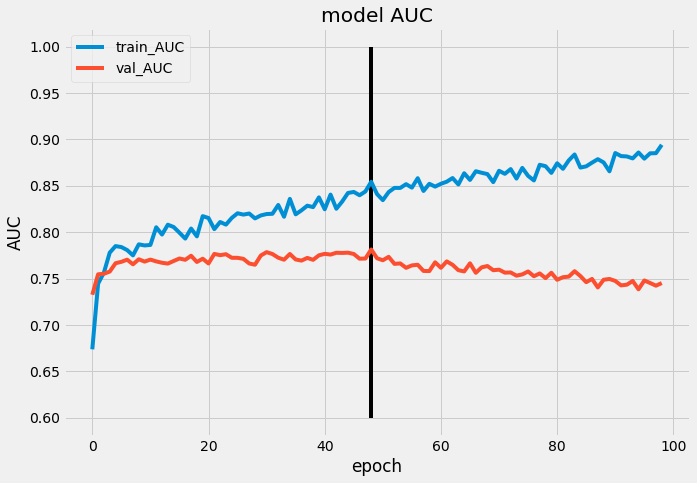

In [380]:
plt.figure(figsize=(10,7))
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.vlines(x=48, ymin=0.6, ymax = 1)
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train_AUC', "val_AUC"], loc='upper left')
plt.savefig('images/history_NN.png')
plt.show()

In [12]:
predictions_FFNN = model.predict(X_test.to_numpy())
rounded_FFNN = [round(x[0]) for x in predictions_FFNN]

accuracy_FFNN = np.mean(rounded_FFNN == Y_test)
auc_FFNN = metrics.roc_auc_score(Y_test, predictions_FFNN)

In [13]:
np.round([accuracy_FFNN, auc_FFNN], 3)

array([0.782, 0.781])

In [377]:
import eli5
from eli5.permutation_importance import get_score_importances

def score(X, y):
    y_pred = model.predict(X)
    return metrics.roc_auc_score(y, y_pred)

base_score, score_decreases = get_score_importances(score, X_test.to_numpy(), Y_test.to_numpy())
feature_importances = np.mean(score_decreases, axis=0)

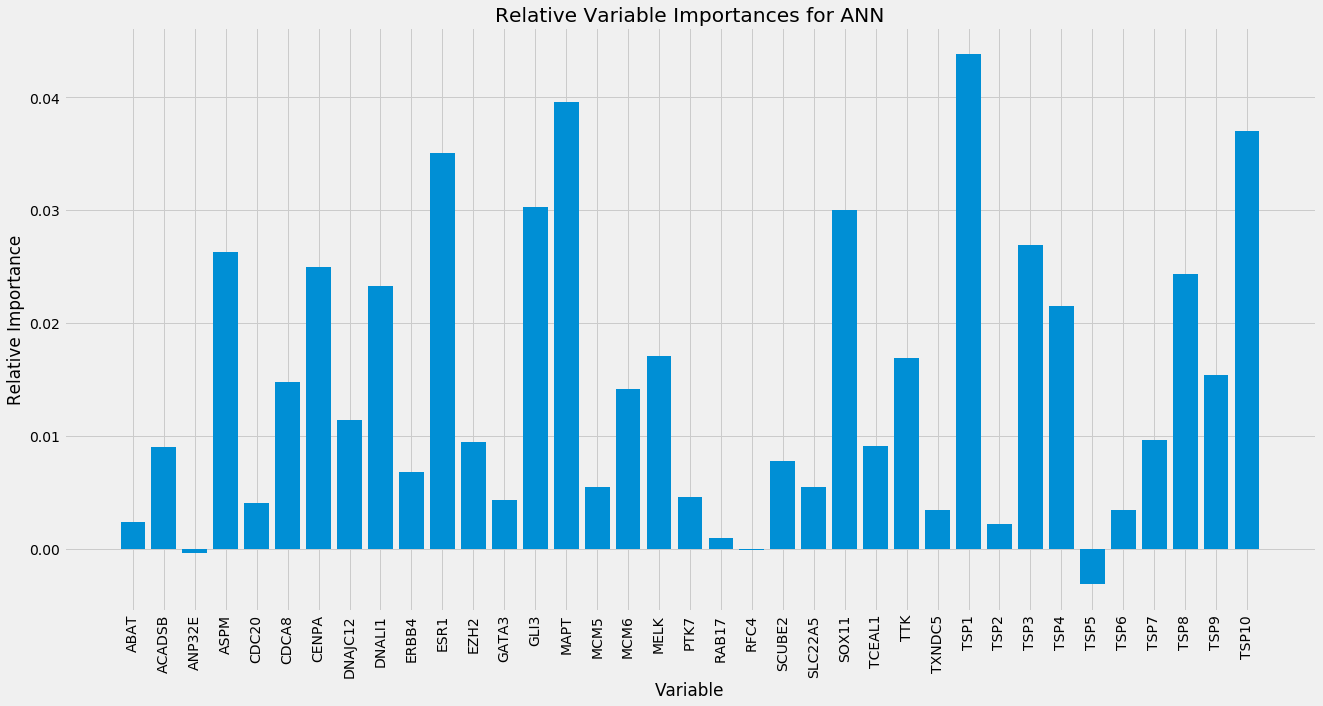

In [378]:
plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(list(feature_importances))))
feature_list = list(X_train_full.columns)
# Make a bar chart
plt.bar(x_values, list(feature_importances), orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Relative Importance'); plt.xlabel('Variable'); plt.title('Relative Variable Importances for ANN');
plt.savefig('images/NN_importances.png')

In [296]:
bad_preds = ["ABAT", "RAB17", "RFC4", "SLC22A5", "TXNDC5", "TSP6", "TSP7"]

In [302]:
# Create model
model_new = Sequential()
model_new.add(Dense(12, input_dim=30, activation='relu'))
model_new.add(Dropout(0.2))
model_new.add(Dense(8, activation='relu'))
model_.add(Dropout(0.2))
model_new.add(Dense(1, activation='sigmoid'))
# add custom optimizer, early stopping, and checkpointing - I tried a variety of optimizers as well
es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      mode='max', verbose=1, patience=50)
mc = tf.keras.callbacks.ModelCheckpoint('models/model_new.h5', 
                                        monitor='val_AUC', 
                                        mode='max', 
                                        save_best_only=True)

# Compile Model
model_new.compile(loss='binary_crossentropy', optimizer=optimize, metrics=['AUC'])

In [303]:
# train model
history = model_new.fit(X_train_full.drop(columns=bad_preds).to_numpy(), Y_train_full.to_numpy(),
                    validation_data=(X_test.drop(columns=bad_preds).to_numpy(), Y_test.to_numpy()),
                    epochs=200, 
                    batch_size=10,
                    callbacks=[es, mc])

Train on 1041 samples, validate on 262 samples
Epoch 1/200
1041/1041 [==============================] - 1s 1ms/sample - loss: 0.6965 - AUC: 0.5719 - val_loss: 0.5454 - val_AUC: 0.6402
Epoch 2/200
1041/1041 [==============================] - 1s 499us/sample - loss: 0.5127 - AUC: 0.6819 - val_loss: 0.5010 - val_AUC: 0.6773
Epoch 3/200
1041/1041 [==============================] - 1s 494us/sample - loss: 0.4962 - AUC: 0.6918 - val_loss: 0.4918 - val_AUC: 0.6935
Epoch 4/200
1041/1041 [==============================] - 1s 494us/sample - loss: 0.4799 - AUC: 0.7154 - val_loss: 0.4884 - val_AUC: 0.6997
Epoch 5/200
1041/1041 [==============================] - 1s 503us/sample - loss: 0.4638 - AUC: 0.7501 - val_loss: 0.4860 - val_AUC: 0.7055
Epoch 6/200
1041/1041 [==============================] - 1s 500us/sample - loss: 0.4668 - AUC: 0.7355 - val_loss: 0.4819 - val_AUC: 0.7134
Epoch 7/200
1041/1041 [==============================] - 1s 494us/sample - loss: 0.4613 - AUC: 0.7543 - val_loss: 0.4803 

In [306]:
predictions_new = model.predict(X_test.drop(columns=bad_preds).to_numpy())
rounded_new = [round(x[0]) for x in predictions_new]

accuracy_new = np.mean(rounded_new == Y_test)
auc_new = metrics.roc_auc_score(Y_test, predictions_new)


In [307]:
np.round([accuracy_new, auc_new], 3)

array([0.798, 0.734])

# Tree Based Models

Decision tree based models like Random Forest classifiers and Gradient Boosting tend to perform well on classification tasks with small to medium sized datasets. Let's adapt a few of these to our task. 

## Random Forest

Let's use a random forest classifier with all of our features. First, we need tune our hyperparameters using cross validation. For computational ease, let's use 3-fold cross validation and a random search algorithm over potential permutations of the n_estimators dictionary defind below. 

In [181]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_full.to_numpy(), Y_train_full.to_numpy())

In [ ]:
# Print the best parameters after a random search of 300 possible combinations
rf_random.best_params_

In [28]:
# Save model 
with open('models/rf', 'wb') as f:
    cPickle.dump(rf_random, f)

In [116]:
# Open model                                                                                                                                                                                                        
with open('models/rf', 'rb') as f:
    rf_random = cPickle.load(f)

In [16]:
# Instantiate model if just want to run once
rf_random = RandomForestRegressor(n_estimators=400, min_samples_split=10,
                           min_samples_leaf=4, max_features='auto',max_depth=70, 
                           bootstrap=True, random_state=42)
rf_random.fit(X_train_full.to_numpy(), Y_train_full.to_numpy())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [17]:
predictions_rf = rf_random.predict(X_test.to_numpy())

rounded_rf = [round(x) for x in predictions_rf]
    
    # Get metrics 
accuracy_rf_full = np.mean(rounded_rf == Y_test.to_numpy())
auc_rf_full = metrics.roc_auc_score(Y_test.to_numpy(), predictions_rf)

In [18]:
np.round([accuracy_rf_full, auc_rf_full], 3)

array([0.786, 0.774])

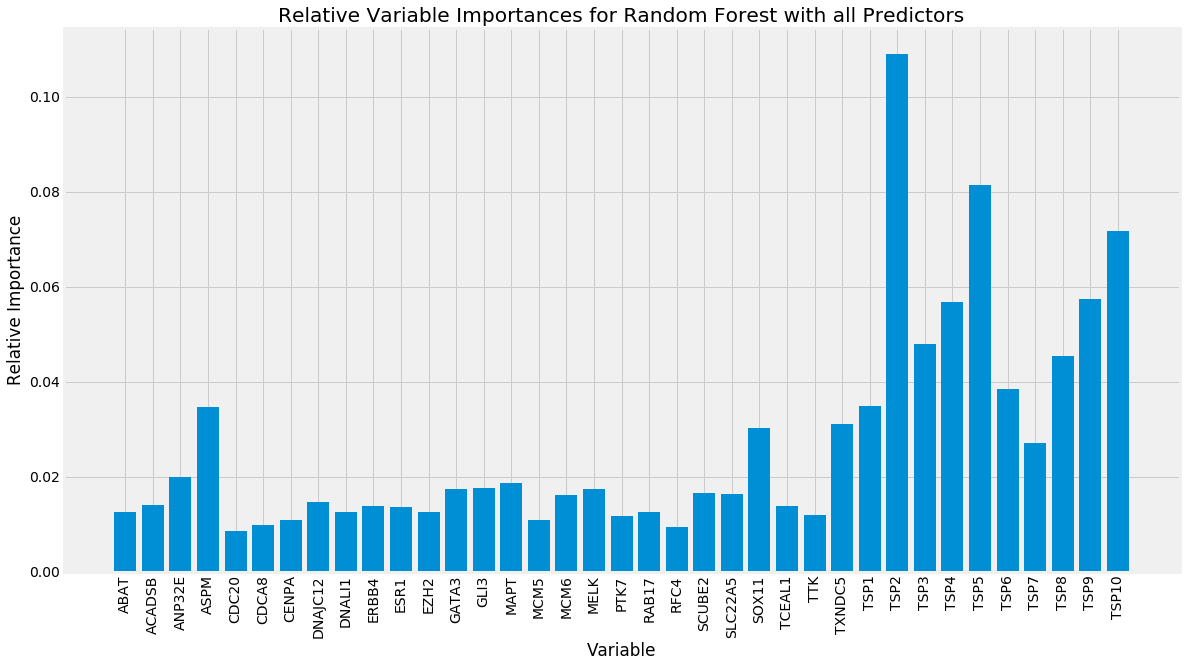

In [33]:

importances = list(rf_random.feature_importances_)
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
feature_list = list(X_train_full.columns)
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Relative Importance'); plt.xlabel('Variable'); plt.title('Relative Variable Importances for Random Forest with all Predictors');
plt.savefig('images/rf_full_var_imp.png')

# Smaller Random Forest

In [34]:
importances_df = pd.DataFrame(rf_random.feature_importances_,columns=["importance"], index = feature_list)
sorted_imp = importances_df.sort_values(by="importance", ascending = False)
keep_index = sorted_imp.loc[sorted_imp["importance"] > 0.02].index


In [35]:
x_train = X_train_full[keep_index].to_numpy()

rf_random = RandomForestRegressor(n_estimators=400, min_samples_split=10,
                           min_samples_leaf=4, max_features='auto',max_depth=70, 
                           bootstrap=True, random_state=42)
rf_random.fit(x_train, Y_train_full.to_numpy())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [36]:
predictions_rf = rf_random.predict(X_test[keep_index].to_numpy())

rounded_rf = [round(x) for x in predictions_rf]
    
    # Get metrics 
accuracy_rf_pithy = np.mean(rounded_rf == Y_test.to_numpy())
auc_rf_pithy = metrics.roc_auc_score(Y_test.to_numpy(), predictions_rf)

In [37]:
np.round([accuracy_rf_pithy, auc_rf_pithy], 3)

array([0.779, 0.769])

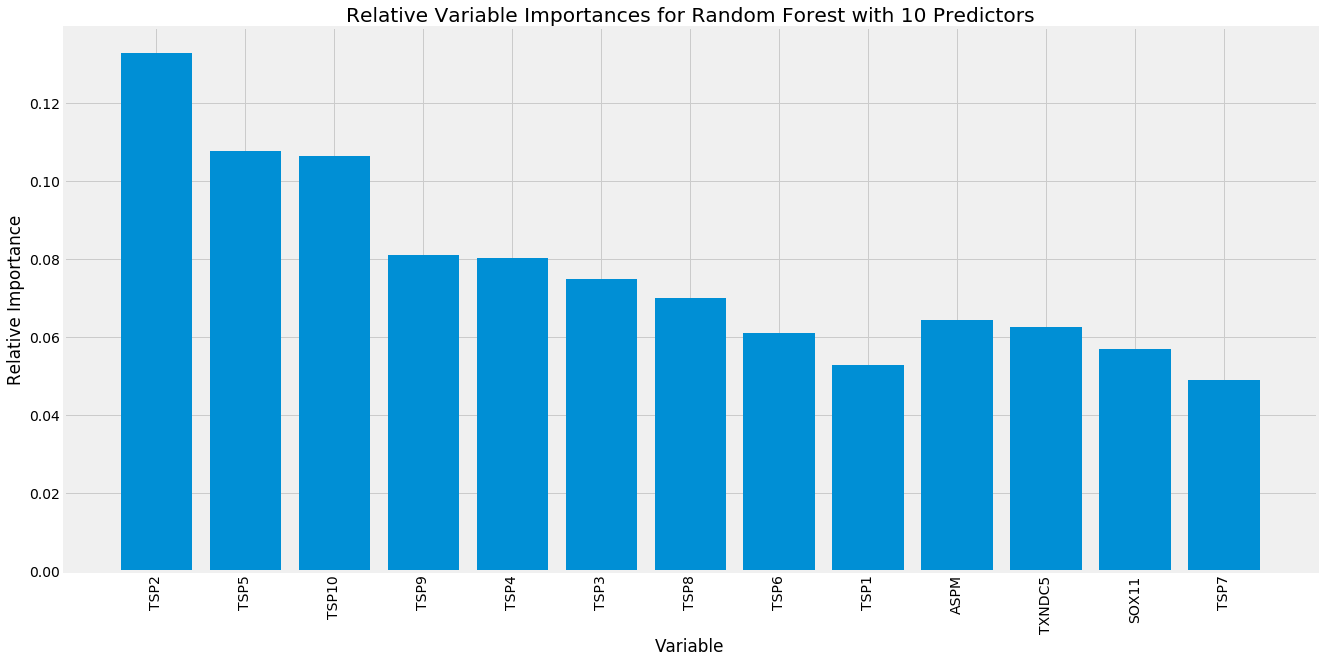

In [319]:
importances = list(rf_random.feature_importances_)
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
feature_list = list(X_test[keep_index].columns)
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Relative Importance'); plt.xlabel('Variable'); plt.title('Relative Variable Importances for Random Forest with 10 Predictors');
plt.savefig('images/rf_pithy_var_imp.png')

# Extreme Gradient Boosting with XGBoost

Sources: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f


In [19]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Loss function for binary outcomes
    'objective':'binary:logistic',
}

In [20]:
params['eval_metric'] = ["auc"]

In [21]:
dtrain = xgb.DMatrix(X_train_full, label=Y_train_full)
dtest = xgb.DMatrix(X_test, label=Y_test)

In [24]:
num_boost_round = 999

### Tune Max_depth/min_child_weight

In [167]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,12)
    for min_child_weight in range(1,8)
]

In [168]:
best_params = None
min_auc = 0
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_auc = cv_results['test-auc-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].values.argmin()
    print("\tauc {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > min_auc:
        min_auc = mean_auc
        best_params = (max_depth,min_child_weight)
        
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], min_auc))

CV with max_depth=1, min_child_weight=1
	auc 0.6981206 for 0 rounds
CV with max_depth=1, min_child_weight=2
	auc 0.6981206 for 0 rounds
CV with max_depth=1, min_child_weight=3
	auc 0.6981206 for 0 rounds
CV with max_depth=1, min_child_weight=4
	auc 0.6981206 for 0 rounds
CV with max_depth=1, min_child_weight=5
	auc 0.6981206 for 0 rounds
CV with max_depth=1, min_child_weight=6
	auc 0.6981206 for 0 rounds
CV with max_depth=1, min_child_weight=7
	auc 0.6981206 for 0 rounds
CV with max_depth=2, min_child_weight=1
	auc 0.7032244000000001 for 0 rounds
CV with max_depth=2, min_child_weight=2
	auc 0.7032244000000001 for 0 rounds
CV with max_depth=2, min_child_weight=3
	auc 0.7041428 for 0 rounds
CV with max_depth=2, min_child_weight=4
	auc 0.7041428 for 0 rounds
CV with max_depth=2, min_child_weight=5
	auc 0.7150610000000001 for 0 rounds
CV with max_depth=2, min_child_weight=6
	auc 0.7150610000000001 for 0 rounds
CV with max_depth=2, min_child_weight=7
	auc 0.7145566000000001 for 0 rounds
CV 

In [169]:
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

### Subsample/colsample

In [170]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [171]:
min_auc = 0
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_auc = cv_results['test-auc-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].values.argmin()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > min_auc:
        min_auc = mean_auc
        best_params = (subsample,colsample)
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], min_auc))

CV with subsample=1.0, colsample=1.0
	AUC 0.7526721999999999 for 0 rounds
CV with subsample=1.0, colsample=0.9
	AUC 0.7479644000000001 for 0 rounds
CV with subsample=1.0, colsample=0.8
	AUC 0.7481422 for 0 rounds
CV with subsample=1.0, colsample=0.7
	AUC 0.7313540000000001 for 0 rounds
CV with subsample=0.9, colsample=1.0
	AUC 0.7458818 for 0 rounds
CV with subsample=0.9, colsample=0.9
	AUC 0.7258598 for 0 rounds
CV with subsample=0.9, colsample=0.8
	AUC 0.7342458 for 0 rounds
CV with subsample=0.9, colsample=0.7
	AUC 0.726112 for 0 rounds
CV with subsample=0.8, colsample=1.0
	AUC 0.7171018 for 0 rounds
CV with subsample=0.8, colsample=0.9
	AUC 0.7159376 for 0 rounds
CV with subsample=0.8, colsample=0.8
	AUC 0.7181168 for 0 rounds
CV with subsample=0.8, colsample=0.7
	AUC 0.7131408 for 0 rounds
CV with subsample=0.7, colsample=1.0
	AUC 0.7171616000000001 for 0 rounds
CV with subsample=0.7, colsample=0.9
	AUC 0.7146296 for 0 rounds
CV with subsample=0.7, colsample=0.8
	AUC 0.71263799999

In [172]:
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

### Eta

In [173]:
min_auc = 0 
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['auc'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_auc = cv_results['test-auc-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].idxmin()
    print("\tAUC {} for {} rounds\n".format(mean_auc, boost_rounds))
    if mean_auc > min_auc:
        min_auc = mean_auc
        best_params = eta
print("Best params: {}, AUC: {}".format(best_params, min_auc))

CV with eta=0.3
	AUC 0.7526721999999999 for 0 rounds

CV with eta=0.2
	AUC 0.7526721999999999 for 0 rounds

CV with eta=0.1
	AUC 0.7526721999999999 for 0 rounds

CV with eta=0.05
	AUC 0.7526721999999999 for 0 rounds

CV with eta=0.01
	AUC 0.7526721999999999 for 0 rounds

CV with eta=0.005
	AUC 0.7526721999999999 for 0 rounds

Best params: 0.3, AUC: 0.7526721999999999


In [174]:
params['eta'] = best_params

## Final model

In [25]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=50
)

[0]	Test-auc:0.68847
Will train until Test-auc hasn't improved in 50 rounds.
[1]	Test-auc:0.72169
[2]	Test-auc:0.71476
[3]	Test-auc:0.74142
[4]	Test-auc:0.74256
[5]	Test-auc:0.75710
[6]	Test-auc:0.76357
[7]	Test-auc:0.76399
[8]	Test-auc:0.75955
[9]	Test-auc:0.76183
[10]	Test-auc:0.75693
[11]	Test-auc:0.76006
[12]	Test-auc:0.76116
[13]	Test-auc:0.76437
[14]	Test-auc:0.76843
[15]	Test-auc:0.77527
[16]	Test-auc:0.77612
[17]	Test-auc:0.77603
[18]	Test-auc:0.77493
[19]	Test-auc:0.77840
[20]	Test-auc:0.77214
[21]	Test-auc:0.77400
[22]	Test-auc:0.77536
[23]	Test-auc:0.77240
[24]	Test-auc:0.76428
[25]	Test-auc:0.75921
[26]	Test-auc:0.75989
[27]	Test-auc:0.76319
[28]	Test-auc:0.76454
[29]	Test-auc:0.76631
[30]	Test-auc:0.76978
[31]	Test-auc:0.76859
[32]	Test-auc:0.76893
[33]	Test-auc:0.77257
[34]	Test-auc:0.77223
[35]	Test-auc:0.77443
[36]	Test-auc:0.77341
[37]	Test-auc:0.77062
[38]	Test-auc:0.77121
[39]	Test-auc:0.77333
[40]	Test-auc:0.77510
[41]	Test-auc:0.77493
[42]	Test-auc:0.77713
[43]	Tes

In [26]:
predictions_boost = model.predict(dtest, ntree_limit=(model.best_ntree_limit))
rounded_boost = [round(x) for x in predictions_boost]
    
    # Get metrics 
accuracy_boost = np.mean(rounded_boost == Y_test.to_numpy())
auc_boost = metrics.roc_auc_score(Y_test.to_numpy(), predictions_boost)

In [27]:
np.round([accuracy_boost, auc_boost], 3)

array([0.786, 0.78 ])

In [28]:
gain_scores = model.get_score(importance_type="gain")

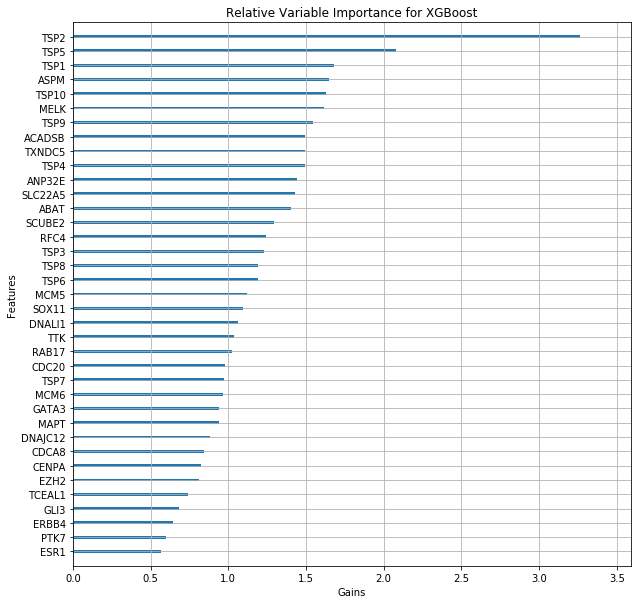

In [29]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10, 10))
plot_importance(model, importance_type="gain",ax=ax, xlabel="Gains", ylabel="Features", show_values =False,
               title="Relative Variable Importance for XGBoost")

plt.savefig('images/gain_xgboost.png')


# Analysis

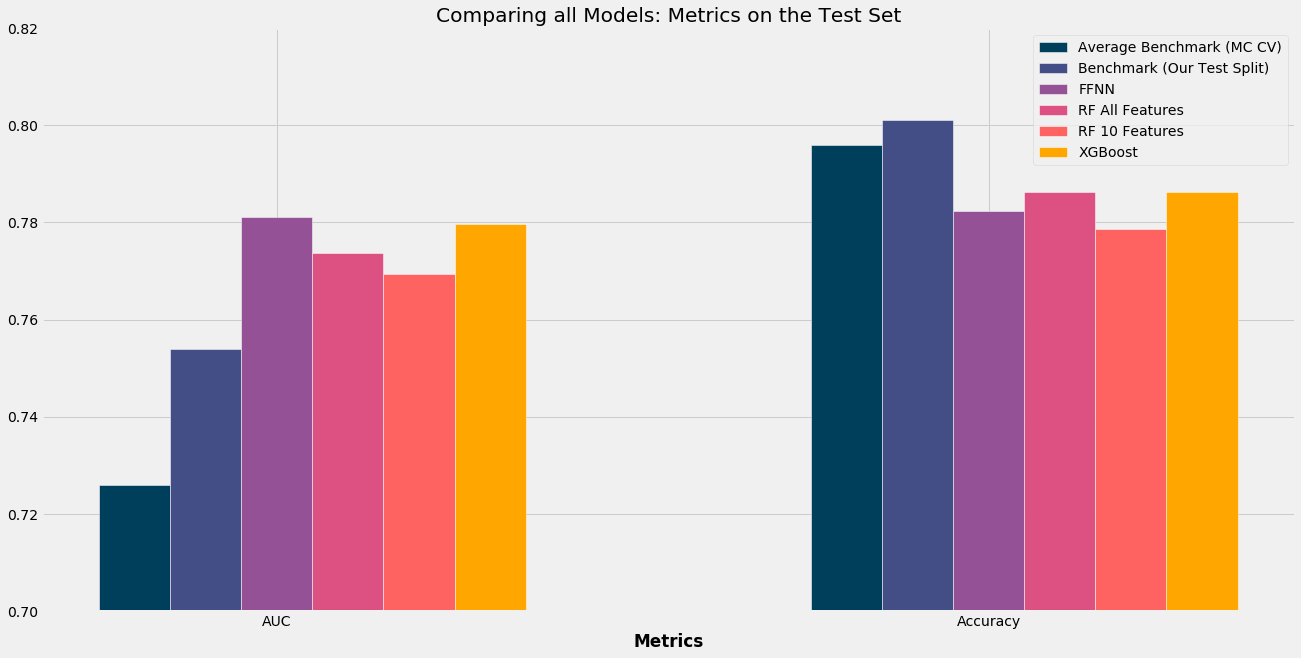

In [39]:
# set width of bar
plt.figure(figsize=(20,10))
barWidth = 0.1
 
# Set position of bar on X axis
r1 = np.arange(2)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
 
# Make the plot
plt.bar(r1, [AUC_BENCHMARK_mc, ACCURACY_BENCHMARK_mc], 
        color="#003f5c", width=barWidth, edgecolor='white', label='Average Benchmark (MC CV)')
plt.bar(r2, [AUC_BENCHMARK, ACCURACY_BENCHMARK], 
        color="#444e86", width=barWidth, edgecolor='white', label='Benchmark (Our Test Split)')
plt.bar(r3, [auc_FFNN, accuracy_FFNN], 
        color="#955196", width=barWidth, edgecolor='white', label='FFNN')
plt.bar(r4, [auc_rf_full, accuracy_rf_full], 
        color='#dd5182', width=barWidth, edgecolor='white', label='RF All Features')
plt.bar(r5, [auc_rf_pithy, accuracy_rf_pithy], 
        color='#ff6361', width=barWidth, edgecolor='white', label='RF 10 Features')
plt.bar(r6, [auc_boost, accuracy_boost], 
        color='#ffa600', width=barWidth, edgecolor='white', label='XGBoost')
 
# Add xticks on the middle of the group bars
plt.xlabel('Metrics', fontweight='bold')
plt.xticks([r + 2*barWidth for r in range(2)], ["AUC", "Accuracy"])
 
plt.ylim(bottom=0.7,top=0.82)
# Create legend & Show graphic
plt.legend(loc="best")
plt.title("Comparing all Models: Metrics on the Test Set")
plt.savefig('images/comparison.png')
plt.show()